In [17]:
#import the different packages used throughout
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import pairwise_distances, davies_bouldin_score
from mpl_toolkits.basemap import Basemap
from bayes_opt import BayesianOptimization

%matplotlib inline

In [13]:
#function that fits dbscan for given parameters and returns the davies bouldin score evaluation metric 
def dbscan_eval_db(eps,min_samples,data):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(data)
    labels = model.labels_
    if len(set(labels))<2:
        score = 0
    else:
        score = davies_bouldin_score(data, labels)
        
    return score

In [14]:
#function that fits dbscan for given parameters and returns the silhouette score evaluation metric 
def dbscan_eval_sil(eps,min_samples,data):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(data)
    labels = model.labels_
    if len(set(labels))<2:
        score = 0
    else:
        score = metrics.silhouette_score(data,labels)
        
    return score

In [15]:
#Applies bayesian optimization to determine DBSCAN parameters that maximize the evaluation metric (specified as input)
def optimize_dbscan(data,metric='silhouette'):
    """Apply Bayesian Optimization to DBSCAN parameters."""
    def dbscan_evaluation_sil(EPS, min_samp):
        """Wrapper of DBSCAN evaluation."""
        min_samp = int(min_samp) #insure that you are using an integer value for the minimum samples parameter
        return dbscan_eval_sil(eps=EPS, min_samples=min_samp, data=data)

    def dbscan_evaluation_db(EPS, min_samp):
        """Wrapper of DBSCAN evaluation."""
        min_samp = int(min_samp) #insure that you are using an integer value for the minimum samples parameter
        return dbscan_eval_db(eps=EPS, min_samples=min_samp, data=data)

    if metric == 'davies':
        optimizer = BayesianOptimization(
            f=dbscan_evaluation_db,
            pbounds={"EPS": (.01, 10), "min_samp": (2, 50)}, #bounds on my parameters - these are very rough guesses right now
            random_state=1234,
            verbose=2
        )
        
    else:
        optimizer = BayesianOptimization(
            f=dbscan_evaluation_sil,
            pbounds={"EPS": (.01, 10), "min_samp": (2, 50)}, #bounds on my parameters - these are very rough guesses right now
            random_state=1234,
            verbose=2
        )
    
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)
    return optimizer.max

In [5]:
#This function takes in a file name (downloaded from trmm.atmos.washington.edu) and extracts the variables
#that I care about (latitude, longitude, altitude, surface rain, latent heat). It does the inital data checks and
#throws out profiles with missing information or zero rainfall. It returns the variables I care about that pass these
#checks

def extract_data(file):
    #Extract the data you want from file
    altitude_lh = file.altitude_lh.data
    surf_rain = file.surf_rain.data
    latent_heating = file.latent_heating.data

    lat = file.latitude.data
    lon = file.longitude.data
    time = file.time.data
    
    #create grid of altitude, lat, and lon coordinates
    LAT, ALTITUDE, LON = np.meshgrid(lat, altitude_lh, lon)

    #size of lat and lon as variables
    nlat = len(lat)
    nlon = len(lon)
    nalt = len(altitude_lh)

    #reshape as column vector (note the indicing is now column*ncolumns+row)
    surf_rain = np.reshape(surf_rain,[nlat*nlon])
    LH = np.reshape(latent_heating,[nalt,nlat*nlon])
    ALTITUDE = np.reshape (ALTITUDE,[nalt,nlat*nlon])
    LON = np.reshape (LON,[nalt,nlat*nlon])
    LAT = np.reshape (LAT,[nalt,nlat*nlon])

    #Remove values with NaN and zero rainfall
    surf_R = surf_rain[~np.isnan(surf_rain)]
    surf_r = surf_R[np.nonzero(surf_R)]

    Lat_Heat = LH[:,~np.isnan(surf_rain)]
    Lat_Heat = Lat_Heat[:,np.nonzero(surf_R)]
    Lat_Heat = np.squeeze(Lat_Heat)

    ALTITUDE = ALTITUDE[:,~np.isnan(surf_rain)]
    ALTITUDE = ALTITUDE[:,np.nonzero(surf_R)]
    ALTITUDE = np.squeeze(ALTITUDE)

    LAT = LAT[:,~np.isnan(surf_rain)]
    LAT = LAT[:,np.nonzero(surf_R)]
    LAT = np.squeeze(LAT)

    LON = LON[:,~np.isnan(surf_rain)]
    LON = LON[:,np.nonzero(surf_R)]
    LON = np.squeeze(LON)

    #Remove any profiles where there is missing latent heat info
    surf_r = surf_r[~pd.isnull(Lat_Heat).any(axis=0)]
    LAT = LAT[:,~pd.isnull(Lat_Heat).any(axis=0)]
    LON = LON[:,~pd.isnull(Lat_Heat).any(axis=0)]
    ALTITUDE = ALTITUDE[:,~pd.isnull(Lat_Heat).any(axis=0)]
    Lat_Heat = Lat_Heat[:,~pd.isnull(Lat_Heat).any(axis=0)]
    Time = np.repeat(time,len(surf_r))
    
    return Lat_Heat.T, surf_r.T, ALTITUDE.T, LAT.T, LON.T, Time.T

In [ ]:
#Old code that was used originally to loop through the files in the EPO (eastern Pacific Ocean) for 2018 that I had 
#downloaded to my local machine and repackage observations with rain into monthly files. Those files were then saved
#to my local machine

#for each month, extract the rain events that happen during that month and save it as a new netcdf file
#months = ['01','02','03','04','05','06','07','08','09','10','11','12']
#for m in range(len(months)):
#   #create empty matrices to hold the extracted data
#    Lat_Heat = []
#    surf_r = []
#    ALTITUDE = []
#    LAT = []
#    LON = []
#    TIME = []
#    count = 0
#
#   #loop through each file in the given month folder
#    for file in glob.glob("/Users/Lauren/Documents/NOAA/Precipitation/**/"+months[m]+"/*.nc4", recursive=True):
#        #extract the relevant data I wish to keep
#        L, S, A, la, lo, Ti = extract_data(xr.open_dataset(file))
#       #append the new data in the matrices
#        if count==0:
#            Lat_Heat = L
#            ALTITUDE = A
#            LAT = la
#            LON = lo
#            TIME = Ti
#            count += 1
#        else:
#            Lat_Heat = np.concatenate((Lat_Heat,L),axis =0)
#            ALTITUDE = np.concatenate((ALTITUDE,A),axis =0)
#            LAT = np.concatenate((LAT,la),axis =0)
#            LON = np.concatenate((LON,lo),axis =0)
#            TIME = np.concatenate((TIME,Ti),axis =0)
#        surf_r = np.append(surf_r,S)
# 
#    #package the matrices as a dataset to save as a netcdf
#    data_in_month = xr.Dataset(
#        data_vars = {'Latitude': (('time', 'altitude'),LAT), 
#                     'Longitude': (('time', 'altitude'),LON), 
#                     'Latent_Heat': (('time', 'altitude'), Lat_Heat),
#                     'surface_rain': (('time'), surf_r)},
#        coords = {'time': TIME,
#                 'altitude': ALTITUDE[0,:]})
#
#    #save as a netcdf
#    data_in_month.to_netcdf(path = "EPO_1998_"+months[m]+".nc4", compute = True)


In [6]:
#Load in the data from my local machine (now in the monthly compiled files)

#Create empty matrices
LH = []
SR = []
Longitude = []
Latitude = []
Time = []
count = 1
#for each file in the folder, extract and compile the profiles
for file in glob.glob("*.nc4"):
    ds = xr.open_dataset(file)
    if count==1: 
        LH = ds.Latent_Heat.data
        count +=1
    else:
        LH = np.concatenate((LH,ds.Latent_Heat.data),axis=0)
    SR = np.append(SR,ds.surface_rain.data)
    Latitude = np.append(Latitude,ds.Latitude.data[:,1])
    Longitude = np.append(Longitude,ds.Longitude.data[:,1])
    Time.extend(ds.time.data) #I'm not sure I'm treating the time component properly

In [7]:
#Translate the time into delta time since the first datapoint (in hours)
InitialTime = np.min(Time)
DeltaTime = []
DeltaTime[:] = [int(x-InitialTime)/(10**9*60*60) for x in Time] #from nanoseconds to hours
DeltaTime = np.array(DeltaTime) #convert from list to array

In [8]:
#Combine the time, latitude, longitude, and rain rate together for training data to cluster rain events
#Note - I've scaled the time to be 4 hours = 1 to make sure the clustering is weighted properly along the different dimensions
#this can still be tuned futher
Xdata = np.concatenate((Latitude.reshape(len(Latitude),1),Longitude.reshape(len(Longitude),1),DeltaTime.reshape(len(DeltaTime),1)/4,SR.reshape(len(SR),1)),axis=1)
Xdata = Xdata[np.where(SR>5),:] #Only look at rain events greater than 5 mm/hour - need to confirm units!
Xdata = np.squeeze(Xdata)


In [20]:
#cluster the rain events with dbscan
#use bayesian optimization to find the best parameters
Opt = optimize_dbscan(Xdata[0:200000,:],metric='davies') #it seems like silhouette takes substantially longer?
min_samps = int(Opt['params']['min_samp'])
eps = Opt['params']['EPS']

#fit the model with the 'best' parameters
model = DBSCAN(eps=eps, min_samples=min_samps)
model.fit(Xdata[0:200000,:])

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
print('Done')

#plot the data clustered together
test = Xdata[0:200000,:] 


|   iter    |  target   |    EPS    | min_samp  |
-------------------------------------------------
|  1        | -0.03814  |  1.923    |  31.86    |
|  2        |  0.2944   |  4.383    |  39.7     |
|  3        |  0.4174   |  7.802    |  15.08    |
|  4        |  0.0901   |  2.772    |  40.49    |
|  5        |  0.277    |  9.582    |  44.04    |
|  6        |  0.0      |  0.01     |  2.0      |
|  7        |  0.3754   |  10.0     |  2.0      |
|  8        |  0.2769   |  10.0     |  28.68    |
|  9        |  0.0      |  0.01     |  15.21    |
|  10       |  0.278    |  10.0     |  36.81    |
|  11       |  0.4298   |  10.0     |  9.02     |
|  12       |  0.4264   |  10.0     |  20.43    |
|  13       |  0.2778   |  10.0     |  50.0     |
|  14       |  0.1591   |  3.173    |  50.0     |
|  15       |  0.4286   |  10.0     |  14.71    |
Final result: {'target': 0.4298250154324809, 'params': {'EPS': 10.0, 'min_samp': 9.020020926704786}}
4
Done


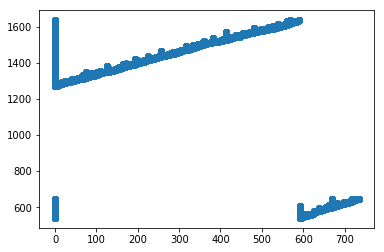

In [55]:
#Look at the time ranges overwhich each cluster extends to see if the time metric is scaled properly
plt.scatter(labels,test[:,2])

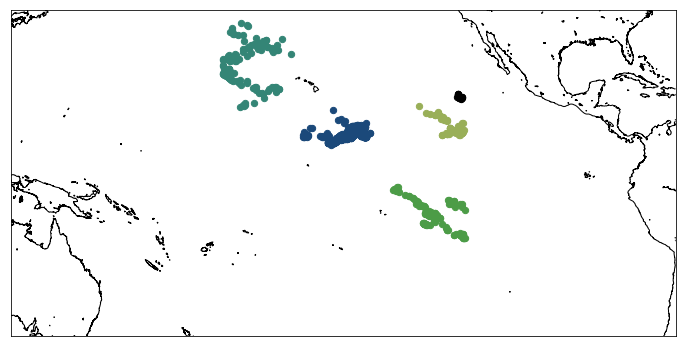

In [16]:
#region overwhich to show the plot
bbox = [np.min(Latitude),np.max(Latitude),
        np.min(Longitude)-50,np.max(Longitude)+50]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
cmap = plt.get_cmap('gist_earth')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()

#look at the clusters within the range labels_min to labels_max
labels_min = np.min(labels)+3
labels_max = 7

#plot the location of rain for the individual clusters (colored by cluster)
for ii in range(labels_min,labels_max):
    cluster = test[labels==ii]
    x,y = m(cluster[:,1],cluster[:,0])
    color_interp = np.interp(ii,[labels_min,labels_max],[0,200])
    plt.scatter(x,y,40,marker='o',color=cmap(int(color_interp)))



In [15]:
#Initial playing around with ML clustering by profiles of heating and rain rate

#combine the latent heat and rain rate at surface together for training data
Xdata = np.concatenate((LH,SR.reshape(len(SR),1)),axis = 1)
Xdata = Xdata[np.where(SR>5),:]
Xdata = np.squeeze(Xdata)

#normalize the data to a zero to one scale
MIN = np.min(Xdata,axis=0)
MAX = np.max(Xdata,axis=0)
np.seterr(divide='ignore', invalid='ignore')
Xdata_scaled = np.subtract(Xdata,MIN)
Xdata_scaled = np.divide(Xdata_scaled,MAX-MIN)
#Xdata_scaled[np.isnan(Xdata_scaled)] = 0

In [18]:
#Playing around with fitting a dbscan on the profiles of LH and surface rain
model = DBSCAN(eps=.05, min_samples=100)
model.fit(Xdata_scaled[0:10000,:])

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
print('Done')


1
Done


(568, 20)
(9432, 20)


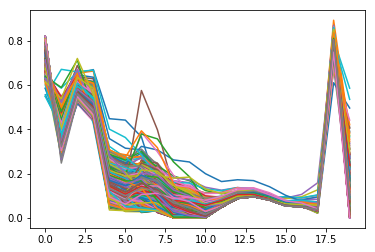

In [19]:
#plot the data clustered together
test = Xdata_scaled[0:10000,:] 

#size of clusters
print(test[labels==-1,:].shape)
print(test[labels==0,:].shape)

plt.plot(test[labels==-1,:].T)


labels = model.labels_
d = {'lat': Latitude, 'lon': Longitude, 'label': labels}
d = pd.DataFrame(data=d)
df = d.groupby(d.columns.tolist(),as_index=False).size()
axes = np.array(df.axes)
values = np.array(df.values)
print(np.array(df.axes))
print(np.array(df.values))
